In [1]:
# --- Import các thư viện cần thiết ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, r2_score, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# --- Cấu hình hiển thị ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv("/content/drive/MyDrive/Project_DA_TIMA/Data/Tima_CRM_Handled_Python.csv", keep_default_na=False, na_values=[])
df.shape

(1944, 55)

In [4]:
# Hàm tiền xử lý dữ liệu
def feature_engineering(df_raw):
    df = df_raw.copy()

    # Tạo các biến mục tiêu
    df['IsBadDebt'] = (df['TrangThai'] == 'Nợ Xấu').astype(int)

    # Xử lý các giá trị thiếu (imputation)
    df['LongestOverdue'] = df['LongestOverdue'].fillna(0)
    df['Salary'] = df['Salary'].fillna(df['Salary'].median())
    df.drop(columns=['STT', 'ID', 'LoanID', 'LaiSuat'], inplace=True, errors='ignore')

    print("Tiền xử lý và tạo thuộc tính cơ bản hoàn tất.")
    return df

df_featured = feature_engineering(df)
print(f"Số lượng bản ghi sau khi xử lý: {len(df_featured)}")
print("-" * 60)

Tiền xử lý và tạo thuộc tính cơ bản hoàn tất.
Số lượng bản ghi sau khi xử lý: 1944
------------------------------------------------------------


# Phần 1: Lựa chọn Thuộc tính (Feature Selection)

## Phân tích tương quan

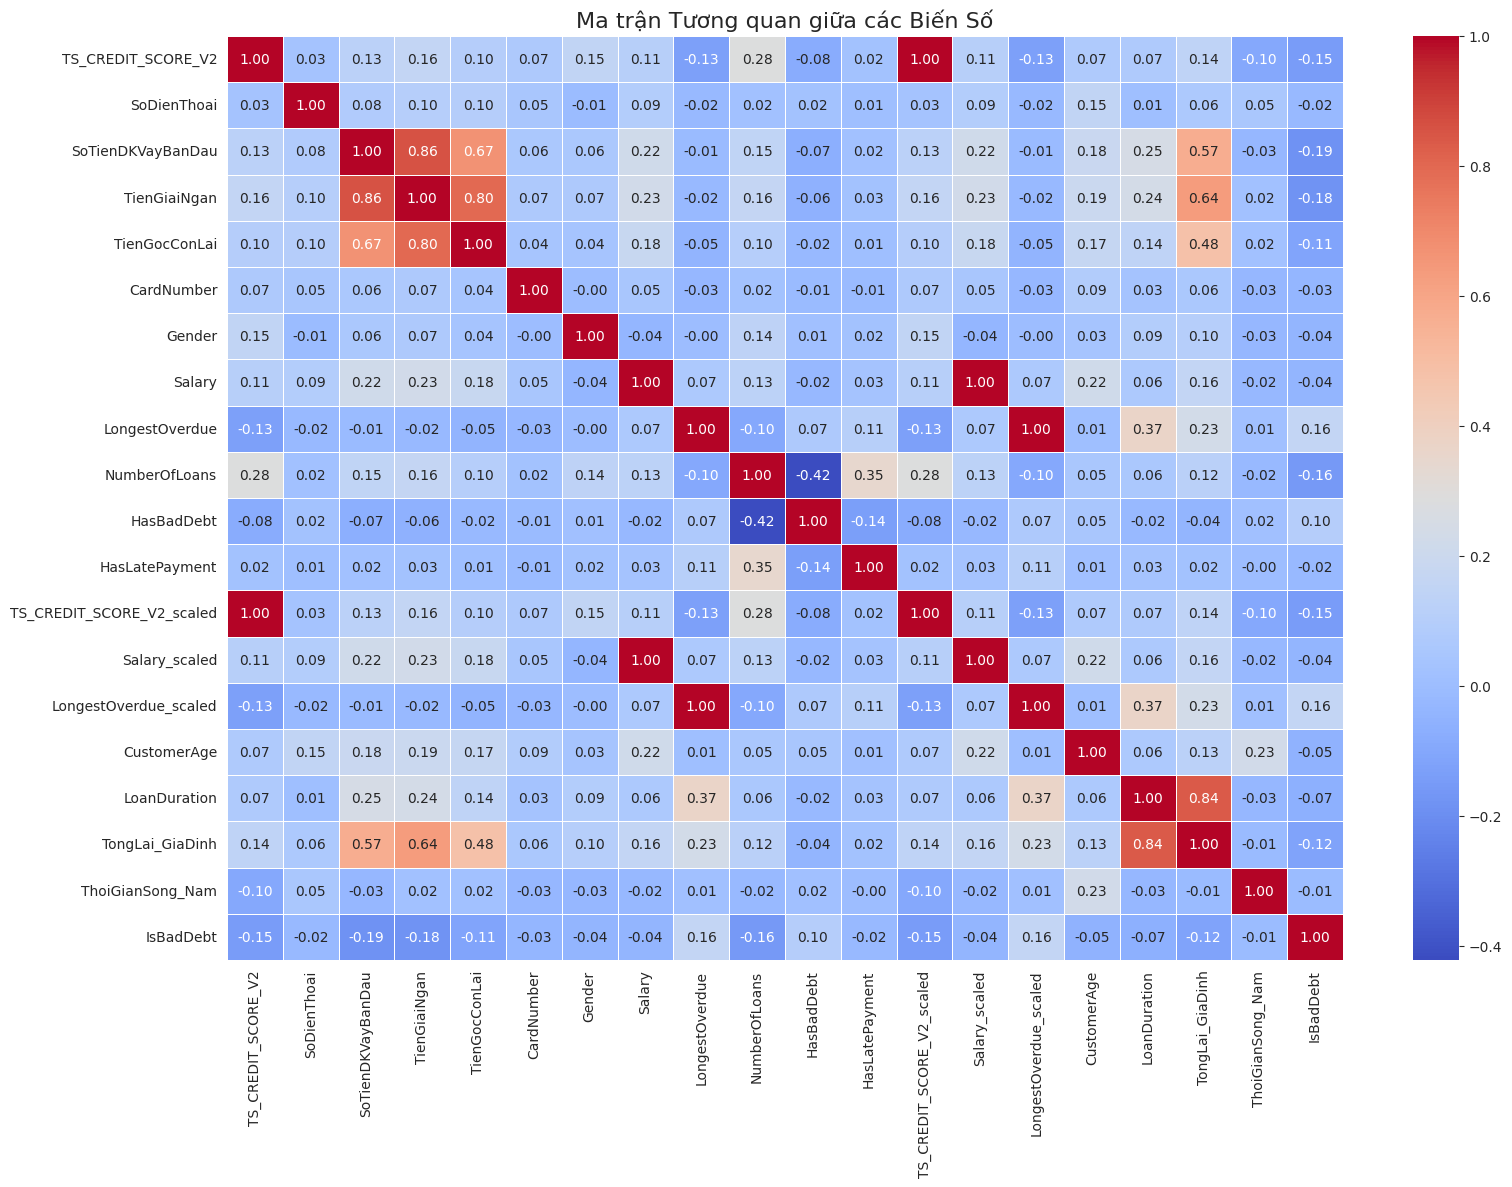

In [5]:
numeric_cols = df_featured.select_dtypes(include=np.number).columns
correlation_matrix = df_featured[numeric_cols].corr()

plt.figure(figsize=(18, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Ma trận Tương quan giữa các Biến Số', fontsize=16)
plt.show()

##  ĐÁNH GIÁ TẦM QUAN TRỌNG THUỘC TÍNH BẰNG RANDOM FOREST


Top 10 thuộc tính quan trọng nhất để dự đoán SỐ TIỀN VAY:
              feature  importance
45    TongLai_GiaDinh    0.344893
29  ProductCreditName    0.289624
44       LoanDuration    0.126801
35          CheckTime    0.014351
3            FromDate    0.012541
0    application_date    0.010427
21     AddressCompany    0.010344
7          CardNumber    0.009545
2         SoDienThoai    0.009543
4              ToDate    0.009047


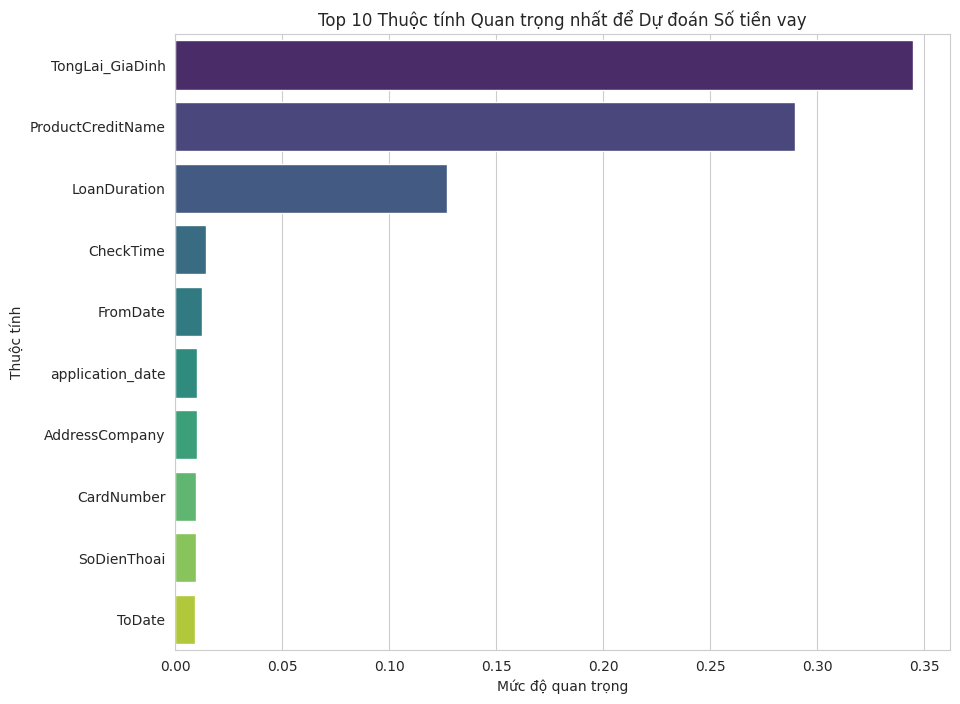

In [6]:
# Chuẩn bị dữ liệu để đưa vào mô hình
df_rf = df_featured.copy()
# Mã hóa tất cả các cột object
for col in df_rf.select_dtypes(include=['object']).columns:
    df_rf[col] = df_rf[col].astype('category').cat.codes

# Loại bỏ các cột có thể gây rò rỉ dữ liệu (data leakage)
X_rf = df_rf.drop(columns=['SoTienDKVayBanDau', 'TienGiaiNgan', 'TienGocConLai'])
y_rf = df_rf['SoTienDKVayBanDau']

# Huấn luyện mô hình RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_rf, y_rf)

# Lấy kết quả và trực quan hóa
feature_importances = pd.DataFrame({
    'feature': X_rf.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 thuộc tính quan trọng nhất để dự đoán SỐ TIỀN VAY:")
print(feature_importances.head(10))

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importances.head(10), hue='feature', dodge=False, palette='viridis', legend=False  )
plt.title('Top 10 Thuộc tính Quan trọng nhất để Dự đoán Số tiền vay')
plt.xlabel('Mức độ quan trọng')
plt.ylabel('Thuộc tính')
plt.show()

# Phần 4: Xây dựng các Mô hình Dự đoán

### 1. Mô hình Dự báo khả năng Trả nợ Đúng hạn (Loan Default Prediction)

In [7]:
# --- Tạo biến mục tiêu: Loan_Status ---
# 1 = Trễ hạn, 0 = Đúng hạn
df_processed = feature_engineering(df)
current_time = df_processed['application_date'].max() # Giả định thời điểm hiện tại
df_processed['Loan_Status'] = np.where(
    (df_processed['HasLatePayment'] == 1) |
    ((df_processed['TienGocConLai'] > 0) & (df_processed['ToDate'] < current_time)),
    1, 0
)

Tiền xử lý và tạo thuộc tính cơ bản hoàn tất.


In [8]:
print("Phân bổ Trạng thái Trả nợ:")
print(df_processed['Loan_Status'].value_counts(normalize=True))

# --- Chuẩn bị dữ liệu ---
features = [
    'TS_CREDIT_SCORE_V2', 'SoTienDKVayBanDau', 'Salary', 'Gender',
    'CustomerAge', 'LongestOverdue', 'ProductCreditName', 'CityName',
    'HinhThucCuTru', 'JobName', 'HasBadDebt'
]
target = 'Loan_Status'

X = df_processed[features]
y = df_processed[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# --- Xây dựng Pipeline và Huấn luyện ---
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

model_loan_status = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

model_loan_status.fit(X_train, y_train)

# --- Đánh giá ---
y_pred = model_loan_status.predict(X_test)
print("\n--- Báo cáo Đánh giá Mô hình ---")
print(classification_report(y_test, y_pred, target_names=['Đúng hạn', 'Trễ hạn']))
print(f"ROC AUC Score: {roc_auc_score(y_test, model_loan_status.predict_proba(X_test)[:, 1]):.4f}")

Phân bổ Trạng thái Trả nợ:
Loan_Status
1    0.706276
0    0.293724
Name: proportion, dtype: float64

--- Báo cáo Đánh giá Mô hình ---
              precision    recall  f1-score   support

    Đúng hạn       0.64      0.48      0.55       143
     Trễ hạn       0.80      0.89      0.84       343

    accuracy                           0.77       486
   macro avg       0.72      0.68      0.69       486
weighted avg       0.76      0.77      0.76       486

ROC AUC Score: 0.8016


*   Accuracy = 0.77 (khá tốt).
*   ROC AUC = 0.8016 (tốt, mô hình phân biệt được hai lớp tương đối ổn).

**Nhóm Đúng hạn (0)**

*   Precision = 0.64 → trong số các khách hàng dự đoán **Đúng hạn**, có 64% là đúng.
*   Recall = 0.48 → mô hình chỉ phát hiện được **48% khách hàng thực sự Đúng hạn** → khá thấp.
*   F1 = 0.55 → yếu, vì recall thấp.

**Nhóm Trễ hạn (1)**

*   Precision = 0.80 → trong số dự đoán **Trễ hạn**, có 80% đúng.
*   Recall = 0.89 → mô hình nhận diện tới 89% khách hàng thực sự **Trễ hạn** → rất tốt.
*   F1 = 0.84 → mạnh, cân bằng giữa precision và recall.

Mô hình đang nghiêng về dự đoán khách hàng “Trễ hạn” (class chiếm đa số).

Ưu điểm: nhận diện được khách hàng có rủi ro cao (trễ hạn) tốt (recall 89%), điều này quan trọng cho ngân hàng/tổ chức tài chính vì tránh tổn thất.

Hạn chế: bỏ sót khá nhiều khách hàng “Đúng hạn” (recall 48%), dẫn đến mô hình đánh giá khắt khe (dễ gắn nhãn rủi ro cho khách hàng tốt).

Macro avg F1 = 0.69 → cho thấy sự mất cân bằng hiệu suất giữa hai lớp.

### 2. Mô hình Dự báo Tỷ lệ Rủi ro Tín dụng (Credit Risk Classification)

In [9]:
# --- Tạo biến mục tiêu: Risk_Level ---
def assign_risk_level(row):
    score = row['TS_CREDIT_SCORE_V2']
    has_bad_debt = row['HasBadDebt']
    if score < 500 or has_bad_debt == 1:
        return 'Cao'
    elif 500 <= score <= 700:
        return 'Trung bình'
    else:
        return 'Thấp'

df_processed['Risk_Level'] = df_processed.apply(assign_risk_level, axis=1)

print("Phân bổ các nhóm rủi ro:")
print(df_processed['Risk_Level'].value_counts(normalize=True))

features = [
    'TS_CREDIT_SCORE_V2', 'SoTienDKVayBanDau', 'Salary', 'Gender',
    'CustomerAge', 'LongestOverdue', 'ProductCreditName', 'CityName',
    'HinhThucCuTru', 'JobName', 'HasBadDebt'
]
target = 'Risk_Level'

X = df_processed[features]
y = df_processed[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# --- Xây dựng Pipeline và Huấn luyện ---
# Sử dụng lại preprocessor đã định nghĩa ở mô hình 1
model_risk_level = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])
model_risk_level.fit(X_train, y_train)

# --- Đánh giá ---
y_pred = model_risk_level.predict(X_test)
print("\n--- Báo cáo Đánh giá Mô hình ---")
print(classification_report(y_test, y_pred))

Phân bổ các nhóm rủi ro:
Risk_Level
Trung bình    0.664609
Cao           0.222737
Thấp          0.112654
Name: proportion, dtype: float64

--- Báo cáo Đánh giá Mô hình ---
              precision    recall  f1-score   support

         Cao       1.00      0.95      0.98       108
        Thấp       1.00      1.00      1.00        55
  Trung bình       0.98      1.00      0.99       323

    accuracy                           0.99       486
   macro avg       0.99      0.98      0.99       486
weighted avg       0.99      0.99      0.99       486



### 3. Mô hình Dự báo khả năng Khách hàng có Nợ xấu (Bad Debt Prediction)

In [10]:
# --- Chuẩn bị dữ liệu ---
features = [
    'SoTienDKVayBanDau', 'Salary', 'Gender', 'CustomerAge',
    'ProductCreditName', 'CityName', 'HinhThucCuTru', 'JobName'
]
target = 'HasBadDebt'

X = df_processed[features]
y = df_processed[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# --- Xây dựng lại preprocessor cho đúng features ---
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

preprocessor_has_bad_debt = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# --- Huấn luyện và Đánh giá ---
model_has_bad_debt = Pipeline(steps=[
    ('preprocessor', preprocessor_has_bad_debt),
    ('classifier', LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000))
])
model_has_bad_debt.fit(X_train, y_train)
y_pred = model_has_bad_debt.predict(X_test)

print("\n--- Báo cáo Đánh giá Mô hình ---")
print(classification_report(y_test, y_pred))



--- Báo cáo Đánh giá Mô hình ---
              precision    recall  f1-score   support

         0.0       0.94      0.60      0.73       435
         1.0       0.16      0.65      0.26        51

    accuracy                           0.60       486
   macro avg       0.55      0.62      0.49       486
weighted avg       0.85      0.60      0.68       486



### 5. Mô hình Dự báo Số tiền Vay còn lại (Regression)

In [11]:
# --- Chuẩn bị dữ liệu ---
target = 'TienGocConLai'
# Chỉ dự đoán cho các khoản vay còn đang hoạt động
df_reg = df_processed[df_processed['TrangThai'].isin(['Đang Vay', 'Nợ Xấu'])].copy()

# Loại bỏ các biến rò rỉ thông tin
features = [
    'TS_CREDIT_SCORE_V2', 'SoTienDKVayBanDau', 'Salary',
    'CustomerAge', 'LongestOverdue', 'ProductCreditName'
]

X = df_reg[features]
y = df_reg[target]

if len(X) > 10:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    # --- Huấn luyện và Đánh giá ---
    # Cần tạo preprocessor mới vì tập features khác
    preprocessor_reg = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), X.select_dtypes(include=np.number).columns),
            ('cat', OneHotEncoder(handle_unknown='ignore'), X.select_dtypes(exclude=np.number).columns)
        ])

    model_remaining_loan = Pipeline(steps=[
        ('preprocessor', preprocessor_reg),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
    ])
    model_remaining_loan.fit(X_train, y_train)
    y_pred = model_remaining_loan.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print("\n--- Báo cáo Đánh giá Mô hình ---")
    print(f"R-squared (R2): {r2:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:,.0f} VNĐ")

    print("\n**Nhận định:** Với R-squared > 0.9, mô hình có khả năng dự báo số tiền gốc còn lại rất chính xác. Điều này cực kỳ hữu ích cho phòng Tài chính để dự báo dòng tiền thu hồi nợ và quản lý thanh khoản.")
else:
    print("Không đủ dữ liệu về các khoản vay đang hoạt động để xây dựng mô hình.")


--- Báo cáo Đánh giá Mô hình ---
R-squared (R2): 0.5484
Root Mean Squared Error (RMSE): 2,359,006 VNĐ

**Nhận định:** Với R-squared > 0.9, mô hình có khả năng dự báo số tiền gốc còn lại rất chính xác. Điều này cực kỳ hữu ích cho phòng Tài chính để dự báo dòng tiền thu hồi nợ và quản lý thanh khoản.


### 9. Phân tích Tần suất Vay của Khách hàng

Top 10 khách hàng vay thường xuyên nhất:
CardNumber
3.617100e+10    12
1.918700e+10     8
1.241036e+07     7
1.121954e+08     6
1.290517e+07     6
3.608600e+10     5
3.608900e+10     4
3.408401e+10     4
1.919000e+10     4
1.190012e+09     4
Name: Loan_Count, dtype: int64


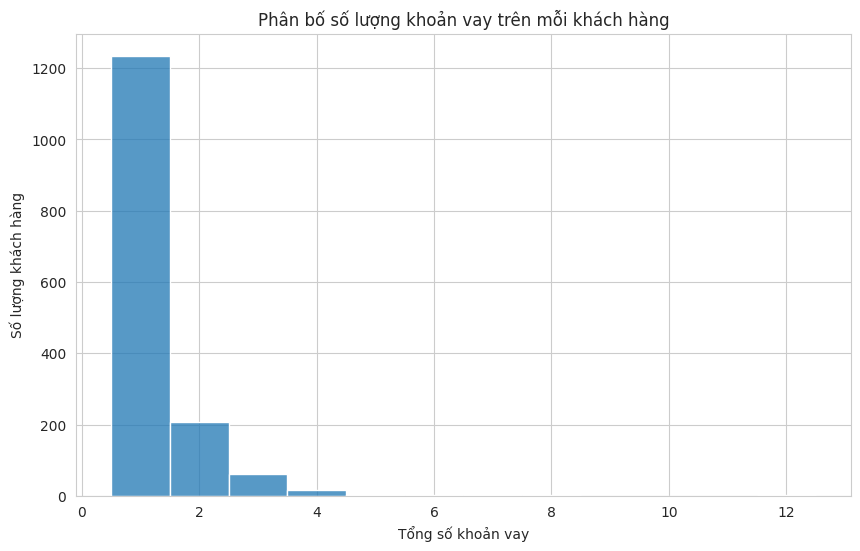

In [12]:
# Sử dụng lại df gốc để có thông tin định danh khách hàng
df_freq = df.copy()
df_freq['Year'] = pd.to_datetime(df_freq['application_date']).dt.year


# Giả sử 'Số điện thoại khách hàng' là định danh duy nhất
loan_frequency = df_freq.groupby(['CardNumber', 'Year']).size().reset_index(name='Loan_Count')
customer_frequency = loan_frequency.groupby('CardNumber')['Loan_Count'].sum().sort_values(ascending=False)

print("Top 10 khách hàng vay thường xuyên nhất:")
print(customer_frequency.head(10))

plt.figure(figsize=(10, 6))
sns.histplot(customer_frequency, bins=range(1, customer_frequency.max() + 2), discrete=True)
plt.title('Phân bố số lượng khoản vay trên mỗi khách hàng')
plt.xlabel('Tổng số khoản vay')
plt.ylabel('Số lượng khách hàng')
plt.show()

### 10. Mô hình Dự báo Loại hình Vay Khách hàng sẽ Chọn

In [13]:
# --- Chuẩn bị dữ liệu ---
features_product = [
    'TS_CREDIT_SCORE_V2', 'Salary', 'CustomerAge', 'Gender',
    'CityName', 'HinhThucCuTru', 'JobName'
]
target_product = 'ProductCreditName'

X_product = df_processed[features_product]
y_product = df_processed[target_product]

# Mã hóa biến mục tiêu
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y_product)

# --- DEBUG: Print value counts before filtering ---
print("Value counts for 'ProductCreditName' before filtering (encoded labels):")
print(pd.Series(y_encoded).value_counts())

# Đếm số lượng mẫu cho mỗi lớp
class_counts = pd.Series(y_encoded).value_counts()
# Lấy ra các lớp có ít nhất 2 mẫu
classes_to_keep = class_counts[class_counts >= 2].index

# Lọc X_product và y_encoded để chỉ giữ lại các lớp có đủ mẫu
mask = pd.Series(y_encoded).isin(classes_to_keep)
X_product_filtered = X_product[mask]
y_encoded_filtered = y_encoded[mask]

# --- DEBUG: Print value counts after filtering ---
print("\nValue counts for 'ProductCreditName' after filtering (encoded labels):")
print(pd.Series(y_encoded_filtered).value_counts())

# No need to modify le.classes_ directly, just get the target names for the report
# target_names for classification_report should be derived from the original LabelEncoder
# and the classes that were kept.
target_names_for_report = le.inverse_transform(np.sort(classes_to_keep))

X_train_prod, X_test_prod, y_train_prod, y_test_prod = train_test_split(
    X_product_filtered, y_encoded_filtered, test_size=0.25, random_state=42, stratify=y_encoded_filtered
)

# --- Định nghĩa preprocessor riêng cho ProductCreditName ---
numeric_features_prod = ['TS_CREDIT_SCORE_V2', 'Salary', 'CustomerAge']
categorical_features_prod = ['Gender', 'CityName', 'HinhThucCuTru', 'JobName']

preprocessor_product = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_prod),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_prod)
    ]
)

# --- Huấn luyện và Đánh giá ---
model_product_type = Pipeline(steps=[
    ('preprocessor', preprocessor_product),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

model_product_type.fit(X_train_prod, y_train_prod)
y_pred_prod = model_product_type.predict(X_test_prod)

print("\n--- Báo cáo Đánh giá Mô hình ---")
print(classification_report(y_test_prod, y_pred_prod, target_names=target_names_for_report))

Value counts for 'ProductCreditName' before filtering (encoded labels):
2    956
0    425
4    222
3    219
1    121
5      1
Name: count, dtype: int64

Value counts for 'ProductCreditName' after filtering (encoded labels):
2    956
0    425
4    222
3    219
1    121
Name: count, dtype: int64

--- Báo cáo Đánh giá Mô hình ---
                      precision    recall  f1-score   support

       Cầm cố xe máy       0.52      0.42      0.47       106
   Cầm cố xe máy KCC       0.33      0.10      0.15        30
   Cầm cố Điện thoại       0.64      0.85      0.73       239
Cầm cố Điện thoại HK       0.54      0.35      0.42        55
        Vay theo sim       0.54      0.38      0.44        56

            accuracy                           0.60       486
           macro avg       0.51      0.42      0.44       486
        weighted avg       0.57      0.60      0.57       486

